## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [58]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [59]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [60]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [61]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

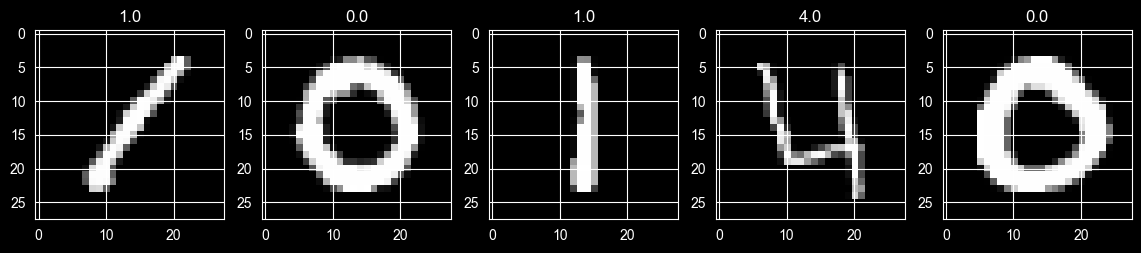

In [62]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [63]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [64]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [65]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [66]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

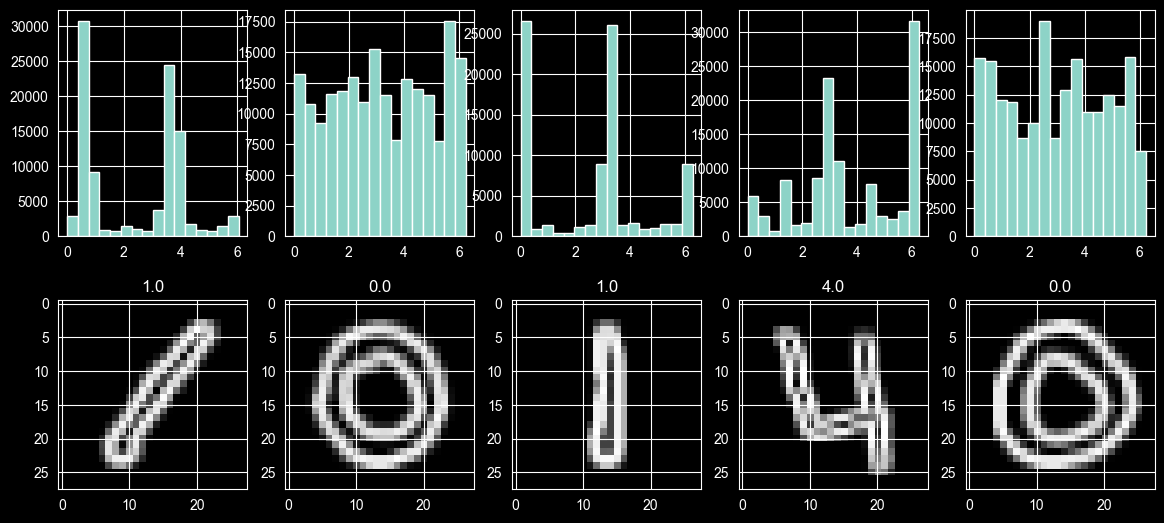

In [67]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [68]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [69]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [70]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [71]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [72]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [73]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [74]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [75]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

KNN - классификатор (Accuracy: 0.5633 - не подходит)

In [76]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
knn.fit(x_train, y_train)

y_knn_pred_val = knn.predict(x_val)

Random Forest - классификатор (Accuracy: 0.6444 - подходит)

In [77]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

clf.fit(x_train, y_train)

y_rf_pred_val = clf.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [78]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_rf_pred_val))

Accuracy: 0.6444047619047619


In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_rf_pred_val))

              precision    recall  f1-score   support

         0.0       0.42      0.39      0.41       816
         1.0       0.98      0.96      0.97       909
         2.0       0.50      0.47      0.49       846
         3.0       0.65      0.69      0.67       937
         4.0       0.72      0.70      0.71       839
         5.0       0.63      0.66      0.64       702
         6.0       0.48      0.46      0.47       785
         7.0       0.86      0.80      0.83       893
         8.0       0.50      0.57      0.53       835
         9.0       0.65      0.69      0.67       838

    accuracy                           0.64      8400
   macro avg       0.64      0.64      0.64      8400
weighted avg       0.65      0.64      0.64      8400



In [80]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_rf_pred_val))

[[317   7  65  30  34  17 125  13 170  38]
 [  1 873   2   0  21   0   2   5   0   5]
 [ 51   0 399 125   2  91  51  19  92  16]
 [ 24   0  78 648   1  91   7   4  76   8]
 [ 16  10  14   3 590   1  82  31   4  88]
 [  5   0  85 104   1 461   7   5  33   1]
 [143   1  58  10  58   7 361  12  72  63]
 [  6   2  29   5  47  12  20 712   6  54]
 [133   0  40  53  10  43  41   4 475  36]
 [ 52   0  25  15  58   6  54  25  26 577]]


## Предсказания на тестовыйх данных

In [81]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

In [82]:
y_rf_pred_test = clf.predict(test_hist)

## Визуализируем предсказания

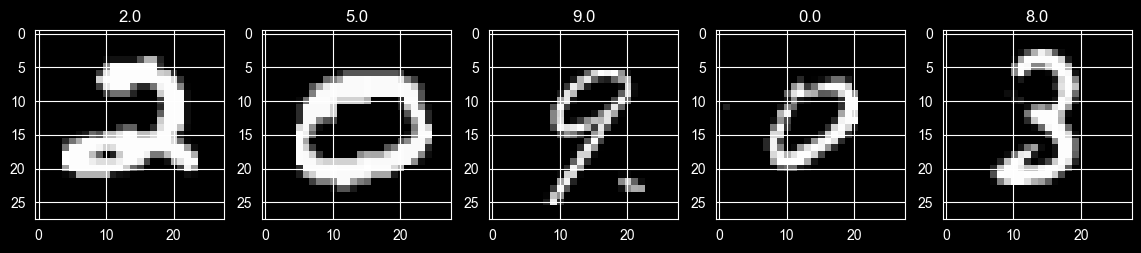

In [83]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % y_rf_pred_test[i - 1])

## Готовим файл для отправки

In [84]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_rf_pred_test.astype(int), 1):
        dst.write('%d,%d\n' % (i, p))

In [85]:
!head submit.csv

ImageId,Label
1,2
2,5
3,9
4,0
5,8
6,7
7,0
8,3
9,3


In [86]:
# Your submission scored 0.41700